<a href="https://colab.research.google.com/github/CaQtiml/Kaggle_Practice/blob/main/FacialKeypoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# files.upload()
# ! mkdir /.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c facial-keypoints-detection
! unzip test
! unzip training


 72% 43.0M/60.1M [00:01<00:01, 14.4MB/s]
100% 60.1M/60.1M [00:01<00:00, 32.9MB/s]
  0% 0.00/843k [00:00<?, ?B/s]
100% 843k/843k [00:00<00:00, 55.9MB/s]
  0% 0.00/201k [00:00<?, ?B/s]
100% 201k/201k [00:00<00:00, 65.4MB/s]
 56% 9.00M/16.0M [00:01<00:00, 7.46MB/s]
100% 16.0M/16.0M [00:01<00:00, 11.1MB/s]
Archive:  test.zip
  inflating: test.csv                
Archive:  training.zip
  inflating: training.csv            


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from time import sleep
import os
import tensorflow as tf
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Flatten, Dense, \
    Dropout, Conv2D,MaxPool2D, ZeroPadding2D, Input, Add, GlobalAveragePooling2D
import matplotlib.pyplot as plt
import cv2
from math import pi

In [ ]:
trainDir = "training.csv"
testDir = "test.csv"
lookIdData = "IdLookupTable.csv"

In [ ]:
train_data = pd.read_csv(trainDir)
test_data = pd.read_csv(testDir)

In [ ]:
# train_data.head(3).T
# test_data.head(3)

In [ ]:
# train_data.isnull().value_counts()
train_data.isnull().any().value_counts()

# There are missing values in 28 columns. 

True     28
False     3
dtype: int64

In [ ]:
train_data.fillna(method = 'ffill',inplace = True)
# https://stackoverflow.com/questions/27905295/how-to-replace-nans-by-preceding-or-next-values-in-pandas-dataframe

In [ ]:
train_data.isnull().any().value_counts()
# No missing value remain.

False    31
dtype: int64

In [ ]:
print(train_data.shape)
print(train_data.columns)

(7049, 31)
Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')


In [ ]:
# chk = True
# m = train_data.shape[0]
# for i in range(m):
#     chk = (len(train_data["Image"][0].split(" "))==9216) and chk
# # len(train_data["Image"][0].split(" "))
# print(chk)

In [ ]:
images = []
m = train_data.shape[0]
# type(train_data["Image"][0])
for i in range(m):
    img = train_data["Image"][i].split(' ')
    img = [float(x) for x in img]
    images.append(img)


In [ ]:
image_list = np.array(images)
image_list = image_list/255.
X = image_list.reshape(-1,96,96,1)

In [ ]:
training = train_data.drop("Image",axis=1)
y = []
for i in range(training.shape[0]):
    yy = training.iloc[i,:]
    y.append(yy)

y = np.array(y)

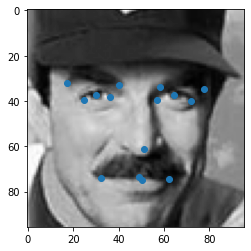

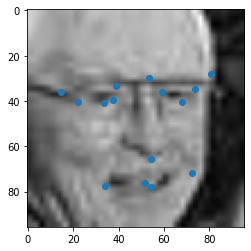

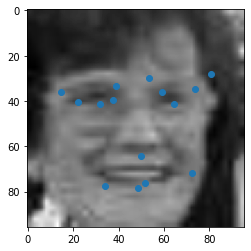

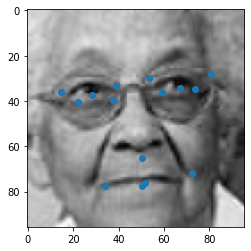

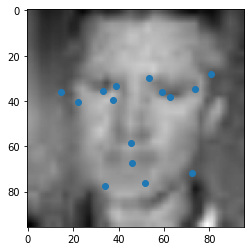

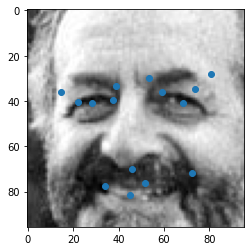

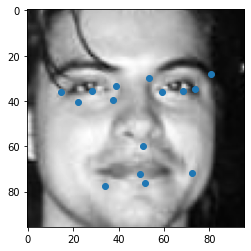

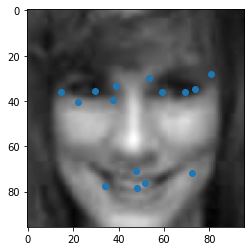

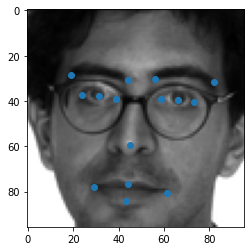

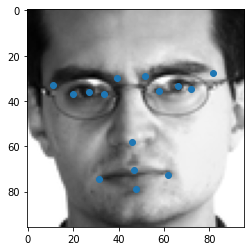

In [ ]:
import random

randlist = random.sample(range(0, 7000), 10)
for j in randlist:
    XX = []
    yy = []
    for i in range(int(y.shape[1]/2)):
        XX.append(y[j][i*2])
        yy.append(y[j][i*2+1])
    plt.figure()
    plt.imshow(np.squeeze(X[j]),cmap='gray')
    plt.scatter(XX,yy)
    plt.show()

In [ ]:
def rotate_augmentation(images,keypoints,rotation_angles):
    rotated_images = []
    all_rotated_keypoints = []
    for x in rotation_angles:
        for angle in [-x,x]:
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_rad = -angle*pi/180.
            for idx in range(images.shape[0]):
                rotated_image = cv2.warpAffine(images[idx], M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
                rotated_keypoints = []
                for idx_kp in range(keypoints.shape[1]):
                    rotated_keypoint = keypoints[idx,idx_kp,:] - 48. # move the center to (0,0) as w/2 and h/2 are 48,48
                    # print(M.shape)
                    # print(rotated_keypoint.shape)
                    M_mul = np.array([
                                        [np.cos(angle_rad), -np.sin(angle_rad)],
                                        [np.sin(angle_rad), np.cos(angle_rad)]
                                    ])
                    # M_mul = M[:,:2]
                    rotated_keypoint = M_mul @ rotated_keypoint
                    rotated_keypoint += 48.
                    rotated_keypoints.append(rotated_keypoint)
                all_rotated_keypoints.append(rotated_keypoints)
    return np.reshape(rotated_images,(-1,96,96,1)),np.array(all_rotated_keypoints)


https://theailearner.com/tag/cv2-getrotationmatrix2d/ \
https://blog.roboflow.com/why-and-how-to-implement-random-rotate-data-augmentation/ \
https://blog.paperspace.com/data-augmentation-for-object-detection-rotation-and-shearing/

In [ ]:
X.shape

(7049, 96, 96, 1)

In [ ]:
X_sample = X
y_sample = y

XY = []
# print(y_sample.shape)
for j in range(y_sample.shape[0]):
    temp = []
    for i in range(int(y_sample.shape[1]/2)):
        x_1 = y[j][i*2]
        y_1 = y[j][i*2+1]
        temp.append([x_1,y_1])
    XY.append(temp)
XY = np.array(XY)
print(XY.shape)
# print(X_sample.shape)
X_aug_sam, y_aug_sam = rotate_augmentation(X_sample,XY,[10,20])


(7049, 15, 2)


In [ ]:
print(X_aug_sam.shape)
print(y_aug_sam.shape)

(28196, 96, 96, 1)
(28196, 15, 2)


In [ ]:
# randlist = random.sample(range(0, 42000), 30)
# for j in randlist:
#     plt.figure()
#     plt.imshow(np.squeeze(X_aug_sam[j]),cmap='gray')
#     plt.scatter(y_aug_sam[j,:,0],y_aug_sam[j,:,1])
#     plt.show()

In [ ]:
X_include_aug = np.concatenate([X,X_aug_sam],axis=0)
y_aug_sam_re = y_aug_sam.reshape(-1,y_aug_sam.shape[1]*y_aug_sam.shape[2])
y_include_aug = np.concatenate([y,y_aug_sam_re],axis=0)
print(X_include_aug.shape)
print(y_include_aug.shape)

(35245, 96, 96, 1)
(35245, 30)


In [ ]:
# test_data.head(3)

In [ ]:
testImages = []
for i in range(test_data.shape[0]):
    img = test_data["Image"][i].split(" ")
    img = [float(x) for x in img]
    testImages.append(img)

In [ ]:
testImages = np.array(testImages)
testImages = testImages/255.
X_test = testImages.reshape(-1,96,96,1)

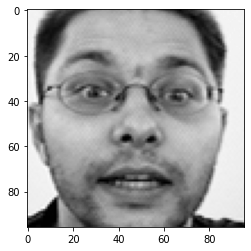

In [ ]:
plt.imshow(np.squeeze(X_test[0]),cmap='gray')
plt.show()

In [ ]:
def identity_block(x, f, filters, training=True):
    # print(x.shape)
    x_shortcut = x
    x = Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x)
    x = BatchNormalization()(x,training=True)

    x = Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x)
    x = BatchNormalization()(x,training=True)

    # print(x.shape)
    # print("---------------")
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)

    return x


In [ ]:
def conv_block(x, f, filters, training=True):
    # print(x.shape)
    x_shortcut = x

    x = Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x)
    x = BatchNormalization()(x,training=True)

    x = Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x)
    x = BatchNormalization()(x,training=True)

    x_shortcut =  Conv2D(filters,f,
               padding = "same",
               activation = "relu")(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut,training=True)

    # print(x.shape)
    # print("---------------")
    x = Add()([x,x_shortcut])
    x = Activation('relu')(x)


    return x


In [ ]:
INPUT_SHAPE = (96,96,1)

inputs = Input(INPUT_SHAPE)
x = conv_block(inputs,3,32)
x = identity_block(x,3,32)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = conv_block(x,3,64)
x = identity_block(x,3,64)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = conv_block(x,3,128)
x = identity_block(x,3,128)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = conv_block(x,3,256)
x = identity_block(x,3,256)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)

x = conv_block(x,3,512)
x = identity_block(x,3,512)
x = MaxPool2D(pool_size=(2, 2), strides=2)(x)


x = GlobalAveragePooling2D()(x)
x = Dense(512,activation='relu')(x)
x = Dropout(0.1)(x)
outputs = Dense(30)(x)



In [ ]:
model = tf.keras.Model(inputs, outputs)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_cv, y_train, y_cv = train_test_split(X_include_aug, y_include_aug, test_size=0.2, random_state=42)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.3, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", # watch the val loss metric
                                                  patience=2)

In [ ]:
model.compile(loss=tf.keras.losses.mse, 
              optimizer=tf.keras.optimizers.Adam(0.0001), 
              metrics=["mae"]) # mae is short for mean absolute error

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=15,
                    validation_data=(X_cv,y_cv),
                    callbacks=[reduce_lr,early_stopping])

Epoch 1/15
882/882 [==============================] - 56s 61ms/step - loss: 98.6077 - mae: 3.9496 - val_loss: 6.5756 - val_mae: 1.6814
Epoch 2/15
882/882 [==============================] - 52s 59ms/step - loss: 5.6647 - mae: 1.5227 - val_loss: 4.6962 - val_mae: 1.3848
Epoch 3/15
882/882 [==============================] - 52s 59ms/step - loss: 4.2779 - mae: 1.2988 - val_loss: 3.9876 - val_mae: 1.2805
Epoch 4/15
882/882 [==============================] - 52s 59ms/step - loss: 3.5194 - mae: 1.1749 - val_loss: 3.3181 - val_mae: 1.1397
Epoch 5/15
882/882 [==============================] - 52s 59ms/step - loss: 2.9423 - mae: 1.0738 - val_loss: 3.1168 - val_mae: 1.1356
Epoch 6/15
882/882 [==============================] - 52s 59ms/step - loss: 2.4751 - mae: 0.9922 - val_loss: 2.8013 - val_mae: 1.0768
Epoch 7/15
882/882 [==============================] - 52s 59ms/step - loss: 2.1436 - mae: 0.9261 - val_loss: 2.8267 - val_mae: 1.0991
Epoch 8/15
882/882 [==============================] - 52s 59m

In [ ]:
model.evaluate(X_cv, y_cv)

221/221 [==============================] - 4s 17ms/step - loss: 1.9105 - mae: 0.8250


[1.9104951620101929, 0.8250111937522888]

In [ ]:
y_cv_pred = model.predict(X_cv)

In [ ]:
# print(yy_pred[0]-yy_test[0])
# print(yy_test[0])

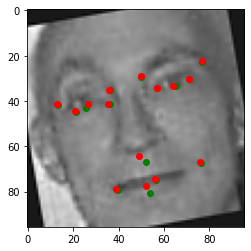

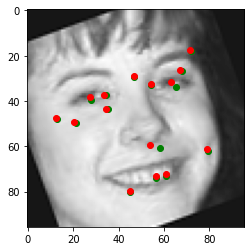

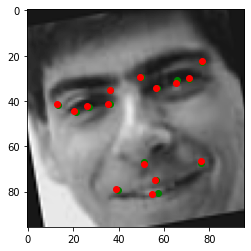

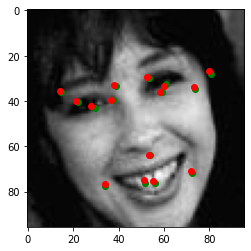

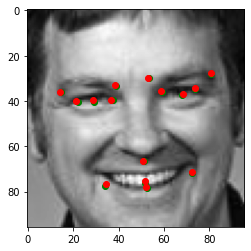

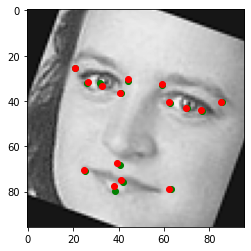

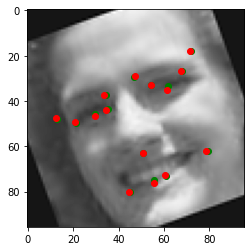

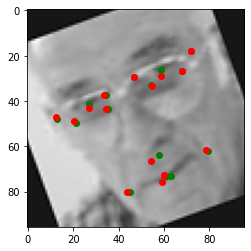

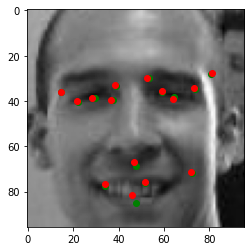

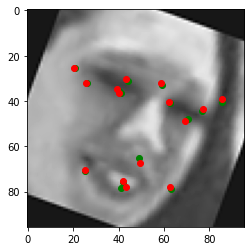

In [ ]:
for j in range(10):
    XX_true = []
    YY_true = []
    XX_pred = []
    YY_pred = []
    for i in range(int(y_cv_pred.shape[1]/2)):
        XX_true.append(y_cv[j][i*2])
        YY_true.append(y_cv[j][i*2+1])
        XX_pred.append(y_cv_pred[j][i*2])
        YY_pred.append(y_cv_pred[j][i*2+1])
    plt.figure()
    plt.imshow(np.squeeze(X_cv[j]),cmap='gray')
    plt.scatter(XX_true,YY_true,color="green")
    plt.scatter(XX_pred,YY_pred,color="red")
    plt.show()

In [ ]:
y_test_pred = model.predict(X_test)

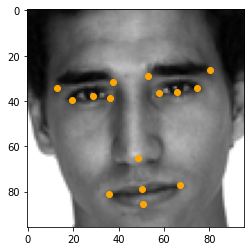

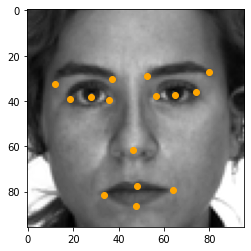

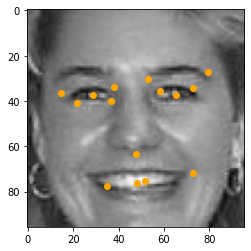

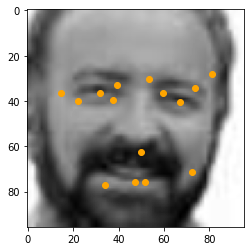

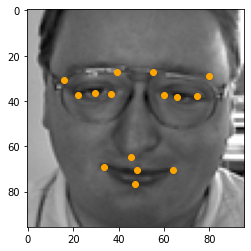

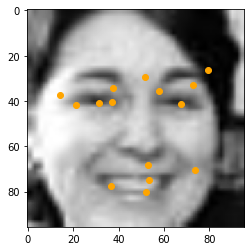

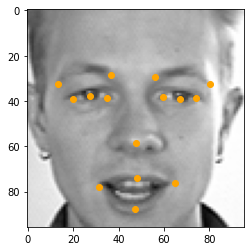

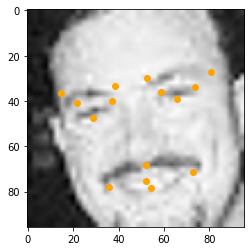

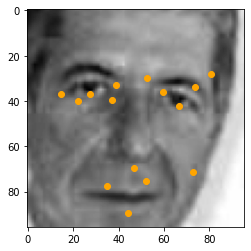

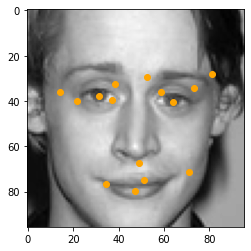

In [ ]:
randlist = random.sample(range(0, 1000), 10)
for j in randlist:
    XX = []
    YY = []
    for i in range(int(y_test_pred.shape[1]/2)):
        XX.append(y_test_pred[j][i*2])
        YY.append(y_test_pred[j][i*2+1])
    plt.imshow(np.squeeze(X_test[j]),cmap='gray')
    plt.scatter(XX,YY,color="orange")
    plt.show()

In [ ]:
lookid_data = pd.read_csv("IdLookupTable.csv")

In [ ]:
lookid_list = list(lookid_data['FeatureName'])
imageID = list(lookid_data['ImageId']-1)
pre_list = list(y_test_pred)

In [ ]:
rowid = lookid_data['RowId']
rowid=list(rowid)

In [ ]:
feature = []
for f in list(lookid_data['FeatureName']):
    feature.append(lookid_list.index(f))

In [ ]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [ ]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)

In [ ]:
submission.to_csv('face_key_detection_submission.csv',index = False)

In [ ]:
!kaggle competitions submit -c facial-keypoints-detection -f face_key_detection_submission.csv -m "Test"

100% 629k/629k [00:07<00:00, 83.3kB/s]
Successfully submitted to Facial Keypoints Detection